In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

Embeds classial data according to the following papers:

The effect of data encoding on the expressive power of variational quantum machine learning models
Maria Schuld, Ryan Sweke, Johannes Jakob Meyer
https://arxiv.org/abs/2008.08605

Quantum embeddings for machine learning
Seth Lloyd, Maria Schuld, Aroosa Ijaz, Josh Izaac, Nathan Killoran
https://arxiv.org/abs/2001.03622

Supervised quantum machine learning models are kernel methods
Maria Schuld
https://arxiv.org/abs/2101.11020

Circuit-centric quantum classifiers
Maria Schuld, Alex Bocharov, Krysta Svore, Nathan Wiebe
https://arxiv.org/abs/1804.00633

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorflow/quantum/blob/research/q_embed/quantum_embed.ipynb)

First we must install the required libraries

In [ ]:
!pip install -q --upgrade tensorflow==2.7.0

In [ ]:
!pip install -q tensorflow-quantum

Next, we import necessary modules

In [1]:
from matplotlib import pyplot as plt 
import numpy as np

import cirq
import tensorflow as tf
from tensorflow_quantum.python import util
from tensorflow_quantum.python.layers.circuit_executors import expectation

import quantum_embed

Then, we create the data to train on. The input is a range of increasing numbers and the output is a single sine function.

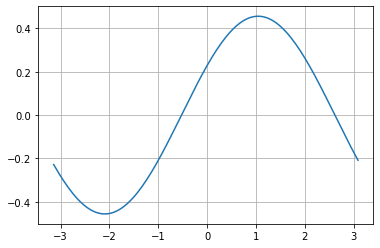

In [2]:
num_examples = 128

data_in = np.linspace(-np.pi, np.pi, num_examples, endpoint=False)
data_out = 0.456 * np.cos(data_in - np.pi / 3.0)

plt.plot(data_in, data_out)
plt.grid()
plt.show()

Since we have a single sine wave, the depth and number of repetions of the circuits are all one. Refer to the paper or the unit tests for more complicated use cases. We then build the quantum embedding layer.

In [3]:
depth_input = 1
num_repetitions = 1
num_repetitions_input = 1
num_unitary_layers = 1

data_in = np.repeat(np.expand_dims(data_in, axis=1), depth_input, axis=1)
data_out = np.repeat(np.expand_dims(data_out, axis=1), depth_input, axis=1)

qubits = [[cirq.GridQubit(i, j) for j in range(depth_input)] for i in range(num_repetitions_input)]
qe = quantum_embed.QuantumEmbed(qubits, num_repetitions_input, depth_input, num_unitary_layers, num_repetitions)

data_circuits = util.convert_to_tensor(
    [cirq.Circuit(qe.build_param_rotator(data_in[m, :])) for m in range(num_examples)])

We then use the Quantum Embedding layer with a standard training.

In [4]:
quantum_datum = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
model_appended = qe(quantum_datum)

batch_size = tf.gather(tf.shape(quantum_datum), 0)
operators = util.convert_to_tensor([[cirq.Z(qubits[0][0])]])
executor = expectation.Expectation(backend='noiseless',
                                   differentiator=None)
tiled_up_operators = tf.tile(qe._operators, [batch_size, 1])

outputs = executor(model_appended,
                   symbol_names=qe.symbols,
                   operators=tiled_up_operators)

model = tf.keras.Model(inputs=quantum_datum, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.3),
              loss=tf.keras.losses.mean_squared_error)

history = model.fit(x=data_circuits, y=data_out, epochs=50)

Epoch 1/50
4/4 [==============================] - 1s 10ms/step - loss: 0.4323
Epoch 2/50
4/4 [==============================] - 0s 10ms/step - loss: 0.1643
Epoch 3/50
4/4 [==============================] - 0s 10ms/step - loss: 0.1197
Epoch 4/50
4/4 [==============================] - 0s 10ms/step - loss: 0.1004
Epoch 5/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0256
Epoch 6/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0200
Epoch 7/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0082
Epoch 8/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0126
Epoch 9/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0056
Epoch 10/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0051
Epoch 11/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0030
Epoch 12/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0030
Epoch 13/50
4/4 [==============================] - 0s 10ms/st

Finally, we plot the loss in log scale. We tend to zero, since it can be fit perfectly.

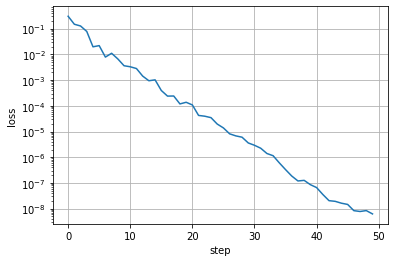

In [5]:
plt.semilogy(history.history['loss']);
plt.grid();
plt.xlabel('step');
plt.ylabel('loss');